In [1]:
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
from torch.utils.data import Dataset, dataloader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import torch.onnx
import matplotlib.pyplot as plt
import pickle as p
from landing_club_wrapper import LandingClubWrapper

pd.options.display.max_rows=999

In [2]:
FULL_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4.csv'
SMALL_SAMPLE_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_sample.csv'
SMALL_HEAD_DATASET_NAME = 'data/landing_club/accepted_2007_to_2018Q4_small_head.csv'

Sample a few records for faster work

In [3]:
# Make small dataset
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc', 'purpose', 'addr_state', 'term', 'emp_length', 'int_rate']
# col_names = ['loan_amnt', 'home_ownership', 'annual_inc','term', 'emp_length', 'int_rate']
COL_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc', 'int_rate']
FEATURE_NAMES = ['loan_amnt', 'home_ownership', 'annual_inc']
LABEL_NAME = 'int_rate'
record_count = 1000
# acc_raw_df = pd.read_csv(FULL_DATASET_NAME)
# acc_raw_df.sample(record_count).to_csv(SMALL_SAMPLE_DATASET_NAME, columns=col_names)
# acc_raw_df.head(record_count).to_csv(SMALL_HEAD_DATASET_NAME, columns=col_names)

## Data Preparation
Training and validation data preparation is combined in this class

In [4]:

class Landing_Club_Dataset(Dataset):
    def __init__(self, file_path: str, col_label, col_names = []):
        self.sc_x = StandardScaler()
        self.sc_y = StandardScaler()
        self.label_enc = LabelEncoder()
        self.file_path = file_path
        self.col_label = col_label
        self.col_names = col_names
        self.read_and_preprocess_datafile()
        
    def read_and_preprocess_datafile(self):
        self.df = pd.read_csv(self.file_path, usecols = self.col_names)
        self.clean()
        self.split_features_and_labels() # split feature columns and label column
        self.encode_categorical_columns()
        self.split_train_test_and_standardize(test_size=.2)
        self.to_tensor()
        self.wrapper = LandingClubWrapper(self.sc_x, self.sc_y, self.label_enc)
        self.write_model_wrapper()
            
    def __get_item__(self, index: int):
        return (self.X_tsor[index], self.y_tsor[index])
    
    def __len__(self):
        return len(self.df)
    
    def to_numpy(self):
        return self.df.to_numpy()
    
    def to_tensor(self, with_grad=False):
        self.X_tsor = torch.tensor(DataFrame.to_numpy(self.X_df), requires_grad=with_grad)
        self.y_tsor = torch.tensor(self.y_df, requires_grad=with_grad)
    
    def clean(self):
        self.df.dropna(inplace=True)
        return
    
    def encode_categorical_columns(self):
        categorical_cols = list(self.X_df.select_dtypes(include=['object']))
        for col in categorical_cols:
            label_encoded = self.label_enc.fit_transform(self.X_df[col])
            self.X_df[col] = label_encoded

    def split_features_and_labels(self):
        self.X_df = self.df.drop(columns=[self.col_label])
        self.y_df = self.df[self.col_label]

    def split_train_test_and_standardize(self, test_size):
        X_train_orig, X_test_orig, y_train_orig, y_test_orig = \
            train_test_split(self.X_df.values, self.y_df.values, test_size=test_size, shuffle=False)

        y_train_orig = y_train_orig.reshape(-1, 1)
        y_test_orig = y_test_orig.reshape(-1, 1)

        self.X_train = LandingClubWrapper.standardize(self.sc_x, X_train_orig, True)
        self.X_test = LandingClubWrapper.standardize(self.sc_x, X_test_orig, False)
        self.y_train = LandingClubWrapper.standardize(self.sc_y, y_train_orig, True)
        self.y_test = LandingClubWrapper.standardize(self.sc_y, y_test_orig, False)

    def get_train_dataset(self):
        X_train_tsor = torch.from_numpy(self.X_train.astype(np.float32))
        y_train_tsor = torch.from_numpy(self.y_train.astype(np.float32))
        return (X_train_tsor, y_train_tsor)

    def get_test_dataset(self):
        X_test_tsor = torch.from_numpy(self.X_test.astype(np.float32))
        y_test_tsor = torch.from_numpy(self.y_test.astype(np.float32))
        return (X_test_tsor, y_test_tsor)

    def write_model_wrapper(self):    
        wrapper_file = open('landing_club_wrapper.pickle', 'wb')
        p.dump(self.wrapper, wrapper_file)
        wrapper_file.close()
    

In [5]:
dataset = Landing_Club_Dataset(SMALL_HEAD_DATASET_NAME, LABEL_NAME, COL_NAMES)

print(f'scaler x-mean = {dataset.sc_x.mean_}')
print(f'scaler y-mean = {dataset.sc_y.mean_}')

feature_list = [3600.0, 'RENT', 40000.0]
prepared_features = dataset.wrapper.preprocess(*feature_list)
print(f'--- {prepared_features}')
post_y = dataset.wrapper.postprocess(-0.8)
print(f'y_hat = {post_y}')


scaler x-mean = [1.56178125e+04 7.42500000e-01 8.04752829e+04]
scaler y-mean = [12.06955]
--- [-1.3893650448459347, 1.3940472808066202, -0.9487243604900134]
y_hat = 8.613235796921813


Define Model explicitely as a Class

In [6]:
feature_count = len(dataset.X_df.columns)


class ClassModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 5)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(5, 5)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(5, 1)

    def forward(self, X):
        x = self.fc1(X)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


_class_model = ClassModel(feature_count, 1)
_seq_model = nn.Sequential(
    nn.Linear(feature_count, 3),
    nn.Sigmoid(),
    nn.Linear(3, 3),
    nn.Sigmoid(),
    nn.Linear(3, 1)
)

model = _seq_model


Define training objects

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(lr=.5, params=model.parameters())

Create Tensors

In [8]:
(X_train_tsor, y_train_tsor) = dataset.get_train_dataset()
(X_test_tsor, y_test_tsor) = dataset.get_test_dataset()

print(X_train_tsor[0:4])
print(y_train_tsor[0:4])


tensor([[-1.3894, -0.8231, -0.5971],
        [ 1.0500, -0.8231, -0.3627],
        [ 0.5066, -0.8231, -0.4096],
        [ 2.2408, -0.8231,  0.6920]])
tensor([[ 0.4445],
        [-0.0184],
        [-0.2985],
        [ 0.6436]])


Train Model

In [9]:
losses = []
n_epochs = 10000
model.train()
for n in range(n_epochs):
    # outputs = myModel(X_train_tsor)
    outputs = model(X_train_tsor)

    loss = criterion(outputs, y_train_tsor)
    losses.append(loss)
    if (n % (1000) == 0):
        with torch.no_grad():
            peek_output_element = 3
            print(f'Loss on epoch '
                  f'{n:04}: {loss.item():.4f} - '
                  f'interest rate: '
                  f'{dataset.sc_y.inverse_transform(outputs[peek_output_element].reshape(-1,1)).reshape(1).item():.4f}'
                  f'/ '
                  f'{dataset.sc_y.inverse_transform(y_train_tsor[peek_output_element].reshape(-1, 1)).reshape(1).item():.4f}'
                  f'\n{dataset.df.iloc[[peek_output_element]].loc[:, ["loan_amnt", "home_ownership", "annual_inc"]]}'
                  f'\n{X_train_tsor[peek_output_element]} - yhat: {y_train_tsor[peek_output_element]}\n'
                  f'---------------------------------------------------------------------------')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


Loss on epoch 0000: 1.1912 - interest rate: 10.1198/ 14.8500
   loan_amnt home_ownership  annual_inc
3    35000.0       MORTGAGE    110000.0
tensor([ 2.2408, -0.8231,  0.6920]) - yhat: tensor([0.6436])
---------------------------------------------------------------------------
Loss on epoch 1000: 0.9177 - interest rate: 14.0035/ 14.8500
   loan_amnt home_ownership  annual_inc
3    35000.0       MORTGAGE    110000.0
tensor([ 2.2408, -0.8231,  0.6920]) - yhat: tensor([0.6436])
---------------------------------------------------------------------------
Loss on epoch 2000: 0.8971 - interest rate: 14.0646/ 14.8500
   loan_amnt home_ownership  annual_inc
3    35000.0       MORTGAGE    110000.0
tensor([ 2.2408, -0.8231,  0.6920]) - yhat: tensor([0.6436])
---------------------------------------------------------------------------
Loss on epoch 3000: 0.8937 - interest rate: 14.0632/ 14.8500
   loan_amnt home_ownership  annual_inc
3    35000.0       MORTGAGE    110000.0
tensor([ 2.2408, -0.8231,

Validate Predictions

Prediction / Test [0] = [[12.34917151]] / [[9.16999991]]
Prediction / Test [1] = [[13.22548225]] / [[5.31999986]]
Prediction / Test [2] = [[10.44343699]] / [[9.16999991]]
Prediction / Test [3] = [[13.81952075]] / [[8.48999991]]
Prediction / Test [4] = [[11.53635056]] / [[9.79999993]]
Prediction / Test [5] = [[12.03873068]] / [[17.26999983]]
Prediction / Test [6] = [[14.28981624]] / [[19.48000022]]
Prediction / Test [7] = [[9.3753891]] / [[13.98999998]]
Prediction / Test [8] = [[13.98482547]] / [[15.77]]
Prediction / Test [9] = [[13.87631295]] / [[27.99000031]]


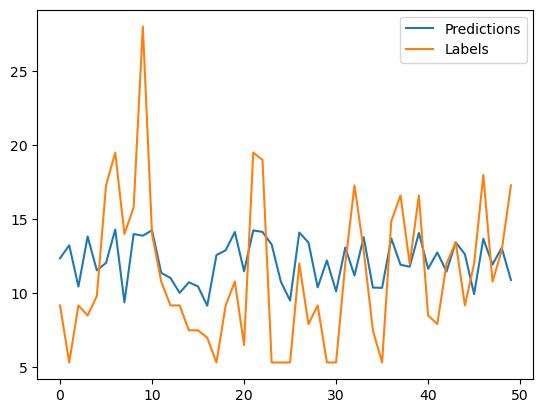

In [10]:
with torch.no_grad():
    model.eval()
    
    preds = model.forward(X_test_tsor)
    # X_test_feat_0 = X_test[2:, 0:1].reshape(-1)
    preds_decoded = dataset.sc_y.inverse_transform(preds)
    y_test_tsor_decoded = dataset.sc_y.inverse_transform(y_test_tsor)
    for i in range(0, 10):
        print(f'Prediction / Test [{i}] = '
              f'{preds_decoded[i].reshape(-1, 1)} / '
              f'{y_test_tsor_decoded[i].reshape(-1, 1)}')
    plt.cla()
    plt.plot(preds_decoded[0:50], label='Predictions')
    plt.plot(y_test_tsor_decoded[0:50], label='Labels')
    plt.legend()


Export ONNX Model

In [11]:
model.eval()
_dummy_input = torch.tensor([[0.1, 0.1, 0.1]])
torch.onnx.export(model, 
                  _dummy_input, 
                  "landing_club_model.onnx",
                  verbose=False,
                  input_names=["features"],
                  output_names=["prediction"],
                  export_params=True)


Test Wrapper